# Практическая работа №6

In [1]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

## Задание №1

Найти данные для кластеризации. Данные в группе не должны повторяться. Если признаки в данных имеют очень сильно разные масштабы, то необходимо данные предварительно нормализовать.

**Теория**:

Кластеризация — это метод анализа данных, который заключается в разделении множества объектов на группы (кластеры) таким образом, чтобы объекты внутри одной группы были схожи между собой, а объекты из разных групп существенно отличались. Основная цель кластеризации — выявить скрытые структуры в данных, не прибегая к предварительной классификации или меткам.

In [4]:
# Загрузка данных снова
bank_churn_df = pd.read_csv('./data/pract6/Bank_Churn.csv')

# Удаление столбцов, которые не участвуют в кластеризации
X = bank_churn_df.drop(columns=['CustomerId', 'Surname', 'Geography', 'Gender', 'Exited'])

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Задание №2

Провести кластеризацию данных с помощью алгоритма k-means. Использовать «правило локтя» и коэффициент силуэта для поиска оптимального количества кластеров.

**Теория**:

_Алгоритм k-means_ — это метод кластеризации, который стремится разделить данные на k кластеров, минимизируя расстояние между объектами внутри одного кластера и максимизируя расстояние между объектами из разных кластеров. Основные шаги алгоритма:

1.	Выбирается количество кластеров k, которые мы хотим получить.
2.	Случайным образом выбираются k начальных центроидов — это точки, которые будут представлять центры будущих кластеров.
3.	Каждый объект данных назначается тому кластеру, центроид которого ближе всего к объекту по евклидову расстоянию.
4.	После назначения объектов кластерам вычисляются новые центроиды для каждого кластера — это среднее положение всех объектов внутри кластера.
5.	Шаги 3 и 4 повторяются до тех пор, пока центроиды не перестанут изменяться (или изменения станут минимальными).

_Правило локтя_ — это метод, который помогает выбрать оптимальное количество кластеров в алгоритме k-means. Он основан на графике зависимости “инерции” (суммы квадратов расстояний от точек до центроидов) от количества кластеров k. Инерция уменьшается с увеличением количества кластеров, но после определённого момента снижение становится менее значительным. Точка, где это замедление становится явно заметным, называется “локтем” — она указывает на оптимальное количество кластеров. Графически это выглядит как изгиб, отсюда и название “правило локтя”.

_Коэффициент силуэта_ — это метрика, которая измеряет качество кластеризации. Она показывает, насколько хорошо объект принадлежит своему кластеру по сравнению с другими кластерами. Для каждого объекта рассчитывается:

- $a(i)$ — среднее расстояние до всех других точек внутри того же кластера.
- $b(i)$ — минимальное среднее расстояние до точек из другого кластера (наиболее близкого кластера).

Коэффициент силуэта для объекта i вычисляется как:


$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$


Значения s(i) варьируются от -1 до 1:

- Значение близкое к 1 указывает на то, что объект хорошо отделён от других кластеров и находится внутри своего кластера.
- Значение около 0 говорит о том, что объект расположен на границе между двумя кластерами.
- Отрицательное значение указывает, что объект мог бы принадлежать другому кластеру.

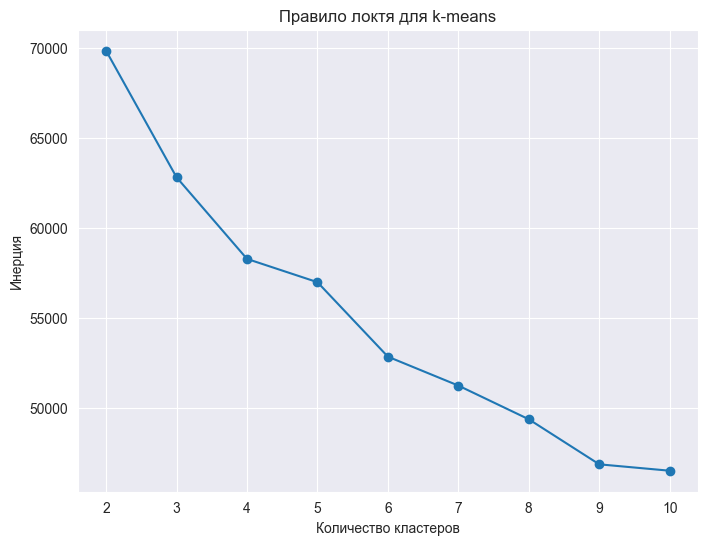

In [5]:
# Кластеризация данных с помощью алгоритма k-means и правило локтя
def elbow_method(x_scaled):
    # Рассчитаем инерцию для разного числа кластеров
    inertia = []
    range_clusters = range(2, 11)
    for k in range_clusters:
        means = KMeans(n_clusters=k, random_state=42)
        means.fit(x_scaled)
        inertia.append(means.inertia_)
    
    # Построение графика для "правила локтя"
    plt.figure(figsize=(8, 6))
    plt.plot(range_clusters, inertia, marker='o')
    plt.title('Правило локтя для k-means')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Инерция')
    plt.grid(True)
    plt.show()

elbow_method(X_scaled)

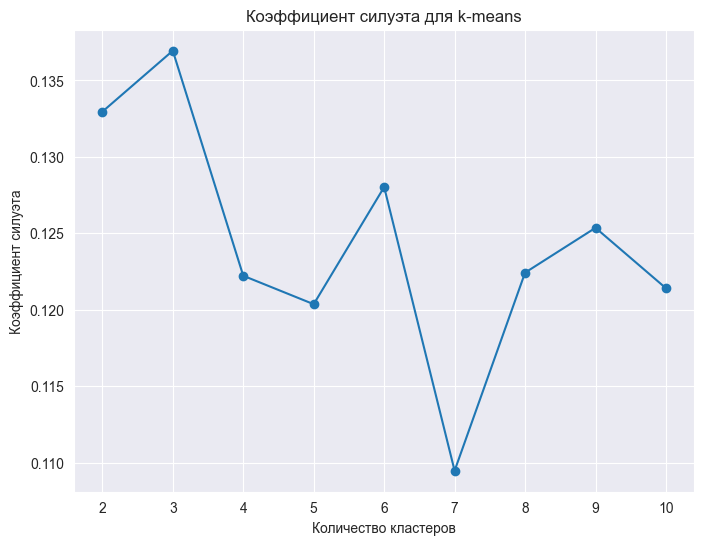

In [6]:
# Коэффициент силуэта для поиска оптимального количества кластеров
def silhouette_analysis(x_scaled):
    range_clusters = range(2, 11)
    silhouette_scores = []
    for k in range_clusters:
        means = KMeans(n_clusters=k, random_state=42)
        means.fit(x_scaled)
        score = silhouette_score(x_scaled, means.labels_)
        silhouette_scores.append(score)

    plt.figure(figsize=(8, 6))
    plt.plot(range_clusters, silhouette_scores, marker='o')
    plt.title('Коэффициент силуэта для k-means')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Коэффициент силуэта')
    plt.grid(True)
    plt.show()

silhouette_analysis(X_scaled)


## Задание №3

Провести кластеризацию данных с помощью алгоритма иерархической кластеризации.

**Теория**:

_Иерархическая кластеризация_ — это метод кластеризации, который создает иерархию кластеров, организованных в виде дерева, называемого дендрограммой. В отличие от метода k-means, который сразу делит данные на фиксированное количество кластеров, иерархическая кластеризация строит последовательность вложенных кластеров, где каждый шаг объединяет или разделяет объекты.

Преимущества:
- Не нужно заранее задавать количество кластеров, как в k-means.
- Можно легко интерпретировать результаты с помощью дендрограммы.
- Хорошо работает на небольших наборах данных.

Недостатки:
- Иерархические методы могут быть очень ресурсоёмкими на больших данных, так как требуют расчета большого числа расстояний.
- Не позволяют пересматривать уже совершенные объединения (агломеративный подход) или разделения (дивизионный подход).
- Чувствительность к шуму и выбросам: выбросы могут сильно влиять на результаты кластеризации.

In [13]:
def hierarchical_clustering(x_scaled):
    hc = AgglomerativeClustering(n_clusters=8)
    labels = hc.fit_predict(x_scaled)
    return labels

# Метки кластеров иерархической кластеризации
labels_hc = hierarchical_clustering(X_scaled)

## Задание №4

Провести кластеризацию данных с помощью алгоритма DBSCAN.

**Теория**:

_DBSCAN_ (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации на основе плотности, который хорошо подходит для выделения кластеров в данных произвольной формы и для обнаружения выбросов. В отличие от методов вроде k-means, DBSCAN не требует заранее задавать количество кластеров и хорошо справляется с шумом (выбросами).

Основная идея DBSCAN заключается в том, что кластеры определяются как области с высокой плотностью данных, разделенные областями с низкой плотностью.

In [60]:
def dbscan_clustering(x_scaled):
    dbscan = DBSCAN(eps=0.9, min_samples=10)
    labels = dbscan.fit_predict(x_scaled)
    return labels

# Метки кластеров DBSCAN
labels_dbscan = dbscan_clustering(X_scaled)

## Задание №5

Визуализировать кластеризованные данные с помощью t-SNE или UMAP, если необходимо. Если данные трехмерные, то можно использовать трехмерный точечный график.

In [19]:
kmeans = KMeans(n_clusters=8, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

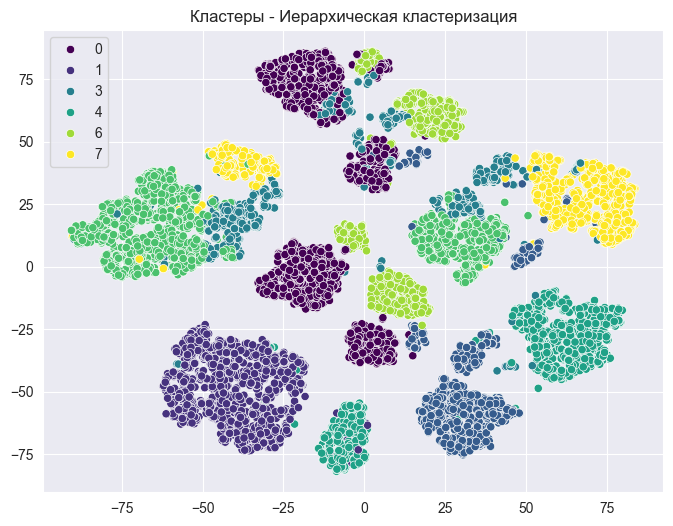

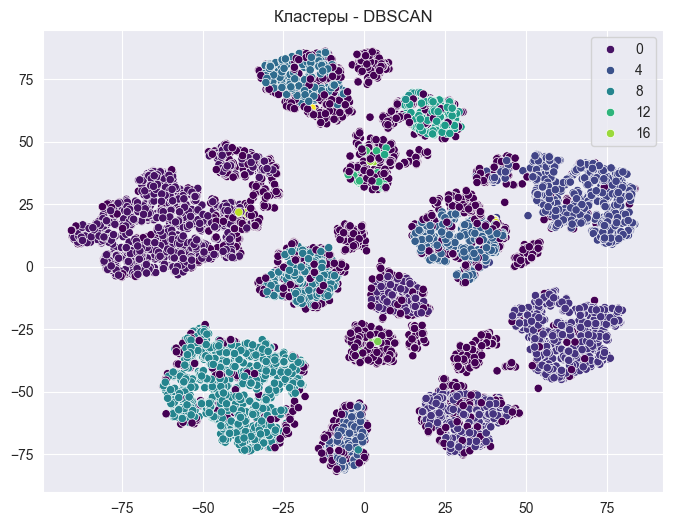

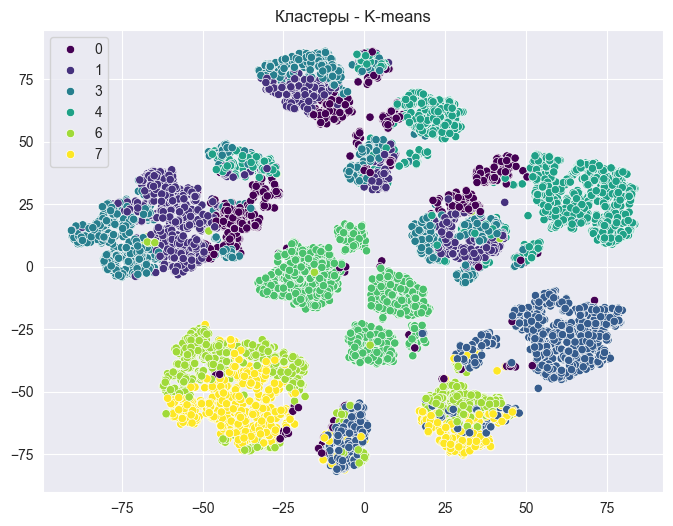

In [61]:
def visualize_clusters(x_scaled, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    x_embedded = tsne.fit_transform(x_scaled)
    
    palette = sns.color_palette("viridis", as_cmap=True)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=labels, palette=palette, legend='auto')
    plt.title(title)
    plt.show()


visualize_clusters(X_scaled, labels_hc, 'Кластеры - Иерархическая кластеризация')
visualize_clusters(X_scaled, labels_dbscan, 'Кластеры - DBSCAN')
visualize_clusters(X_scaled, labels_kmeans, 'Кластеры - K-means')